# COCKATIEL on Different NLP Models

## Set Up

In [1]:
# Move the current path to the repo
%cd "../cockatiel/"

C:\Users\onurp\Desktop\Analitik\cockatiel


In [2]:
# Enable automatical module reload
%load_ext autoreload
%autoreload 2

## Data Analysis and Preprocessing

In [3]:
import pandas as pd
import numpy as np

In [4]:
df_imbdb_clean = pd.read_csv('./data/IMDB_Dataset_clean.csv', index_col=0)
df_imbdb_clean

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,Petter Mattei's Love in the Time of Money is a...,positive
...,...,...
49992,I thought this movie did a down right good job...,positive
49993,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49994,I am a Catholic taught in parochial elementary...,negative
49995,I'm going to have to disagree with the previou...,negative


In [5]:
print(df_imbdb_clean['sentiment'].value_counts())

sentiment
positive    24999
negative    24998
Name: count, dtype: int64


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the word counts of each sentence 
lengths = [len(string.split()) for string in df_imbdb_clean['review']]

print("Max number of words in a sentence:", max(lengths))
print("Min number of words in a sentence:", min(lengths))
print("Avg number of words in a sentence:", round(sum(lengths) / len(lengths)))

Max number of words in a sentence: 500
Min number of words in a sentence: 4
Avg number of words in a sentence: 209


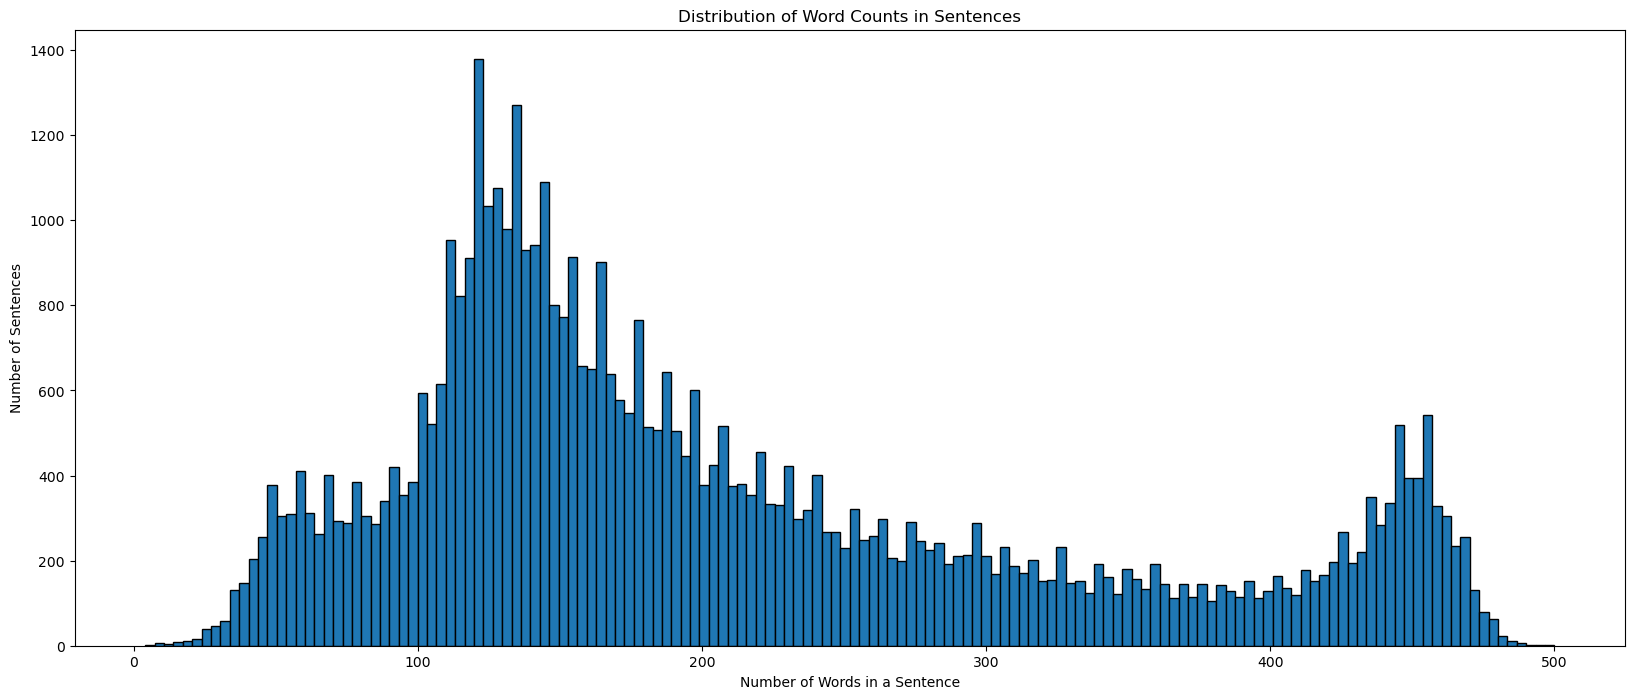

In [7]:
# Generate a histogram to group the data points
hist, bins = np.histogram(lengths, bins=150)

# Create the histogram plot
plt.figure(figsize=(20, 8))
plt.hist(lengths, bins=bins, edgecolor='k')
plt.xlabel('Number of Words in a Sentence')
plt.ylabel('Number of Sentences')
plt.title('Distribution of Word Counts in Sentences')
plt.show()

In [8]:
# Convert the dataset to numpy array
data_np = np.array(df_imbdb_clean)
data_np.shape

(49997, 2)

## Hyperparameters

In [9]:
batch_size = 32

## Load and Inspect Model

In [10]:
import torch

# Set up GPU if it is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Selected component:", device)

Selected component: cuda


In [11]:
# Load the model and its tokenizer

from transformers import RobertaTokenizerFast
from cockatiel import CustomRobertaForSequenceClassification, batch_predict, batcher, tokenize

tokenizer = RobertaTokenizerFast.from_pretrained("wrmurray/roberta-base-finetuned-imdb")
model = CustomRobertaForSequenceClassification.from_pretrained("wrmurray/roberta-base-finetuned-imdb").to(device)

# Put model into evaluation mode
model = model.eval()

2023-10-08 11:58:25,460 SequenceTagger predicts: Dictionary with 47 tags: O, S-NP, B-NP, E-NP, I-NP, S-VP, B-VP, E-VP, I-VP, S-PP, B-PP, E-PP, I-PP, S-ADVP, B-ADVP, E-ADVP, I-ADVP, S-SBAR, B-SBAR, E-SBAR, I-SBAR, S-ADJP, B-ADJP, E-ADJP, I-ADJP, S-PRT, B-PRT, E-PRT, I-PRT, S-CONJP, B-CONJP, E-CONJP, I-CONJP, S-INTJ, B-INTJ, E-INTJ, I-INTJ, S-LST, B-LST, E-LST, I-LST, S-UCP, B-UCP, E-UCP, I-UCP, <START>, <STOP>


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\onurp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\onurp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
# Make predictions on some samples
y_pred, labels = batch_predict(model.forward, tokenizer, data_np[:100], batch_size, device)

# Compute the activations on which to apply the NMF
features, labels = batch_predict(model.features, tokenizer, data_np[:100], batch_size, device)

# Go from these activations to the final prediction
y_pred_bis = model.end_model(features)

print("Accuracy for classic model        :", torch.mean((torch.argmax(y_pred, -1) == labels.to(device)).float()))
print("Accuracy for model in 'two parts' :", torch.mean((torch.argmax(y_pred_bis, -1) == labels.to(device)).float()))

Accuracy for classic model        : tensor(0.9900, device='cuda:0')
Accuracy for model in 'two parts' : tensor(0.9900, device='cuda:0')


In [13]:
import torchsummary as ts

print(ts.summary(model).total_params)

Layer (type:depth-idx)                        Param #
├─RobertaModel: 1-1                           --
|    └─RobertaEmbeddings: 2-1                 --
|    |    └─Embedding: 3-1                    38,603,520
|    |    └─Embedding: 3-2                    394,752
|    |    └─Embedding: 3-3                    768
|    |    └─LayerNorm: 3-4                    1,536
|    |    └─Dropout: 3-5                      --
|    └─RobertaEncoder: 2-2                    --
|    |    └─ModuleList: 3-6                   85,054,464
├─CustomRobertaClassificationHead: 1-2        --
|    └─Linear: 2-3                            590,592
|    └─Dropout: 2-4                           --
|    └─Linear: 2-5                            1,538
├─MSELoss: 1-3                                --
Total params: 124,647,170
Trainable params: 124,647,170
Non-trainable params: 0
124647170


## Prepare Dataset for COCKATIEL

In [14]:
# Store predicted positive (pos) and negative (neg) reviews in lists 

positive_reviews = []
negative_reviews = []

with torch.no_grad():
    for input_batch in batcher(data_np[:20000], batch_size=batch_size):
        
        r = np.array(list(map(lambda z: z[0], input_batch)))

        tokenized_batch = tokenize(r, tokenizer, device)
        
        preds = model(**tokenized_batch)
        
        positive_reviews.extend(list(input_batch[np.where(np.argmax(preds.cpu().numpy(), axis=1) == 1)[0]]))
        negative_reviews.extend(list(input_batch[np.where(np.argmax(preds.cpu().numpy(), axis=1) == 0)[0]]))

raw_dataset_pos = list(map(lambda z: z[0], positive_reviews))
raw_dataset_neg = list(map(lambda z: z[0], negative_reviews))

import pickle

pickle.dump(raw_dataset_pos, open("../Tez/data/for_roberta/raw_dataset_pos.pkl", "wb"))
pickle.dump(raw_dataset_neg, open("../Tez/data/for_roberta/raw_dataset_neg.pkl", "wb"))

In [15]:
# Extract the excerpts as a dataset

sentence_separators = ['.', '...', '?', '!', '..']

def excerpt_fct(raw_dataset):
    
    excerpt_dataset = []
    
    for review in raw_dataset[:100000]:
        
        review = str(review)

        for sep in sentence_separators:
            
            review = review.replace(sep, '.')
  
        cropped_review = review.split('.')
    
        for crop in cropped_review:
            
            if len(crop):
                crop = crop + '.'
                
                while crop[0] == ' ':
                    crop = crop[1:]
      
                if crop[0].isupper():  
                    excerpt_dataset.append(crop)
                
    return excerpt_dataset
  
excerpt_dataset_pos = excerpt_fct(raw_dataset_pos)
excerpt_dataset_neg = excerpt_fct(raw_dataset_neg)

print(len(excerpt_dataset_pos), ' positives excerpts created.')
print(len(excerpt_dataset_neg), ' negatives excerpts created.')

pickle.dump(excerpt_dataset_pos, open("../Tez/data/for_roberta/excerpt_dataset_pos.pkl", "wb"))
pickle.dump(excerpt_dataset_neg, open("../Tez/data/for_roberta/excerpt_dataset_neg.pkl", "wb"))

108194  positives excerpts created.
111385  negatives excerpts created.


In [16]:
import pickle

raw_dataset_pos = pickle.load(open("../Tez/data/for_roberta/raw_dataset_pos.pkl", "rb"))
raw_dataset_neg = pickle.load(open("../Tez/data/for_roberta/raw_dataset_neg.pkl", "rb"))

excerpt_dataset_pos = pickle.load(open("../Tez/data/for_roberta/excerpt_dataset_pos.pkl", "rb"))
excerpt_dataset_neg = pickle.load(open("../Tez/data/for_roberta/excerpt_dataset_neg.pkl", "rb"))

## Train COCKATIEL

In [17]:
from cockatiel import COCKATIEL

len_data = 50000  

In [18]:
# Train COCKATIEL on positive reviews

with torch.no_grad():
    
    cockatiel_explainer_pos = COCKATIEL(model, tokenizer, components=20, 
                                        batch_size=batch_size, device=device)
    # batch size was 64 
    segments_pos, u_segments_pos, factorization_pos, global_importance_pos = cockatiel_explainer_pos.extract_concepts(excerpt_dataset_pos[:len_data], 
                                                                                                                      raw_dataset_pos[:(len_data//10)], 
                                                                                                                      1, limit_sobol=1_000)
    
pickle.dump(segments_pos, open("../Tez/data/for_roberta/segments_pos.pkl", "wb"))
pickle.dump(u_segments_pos, open("../Tez/data/for_roberta/u_segments_pos.pkl", "wb"))
pickle.dump(factorization_pos, open("../Tez/data/for_roberta/factorization_pos.pkl", "wb"))
pickle.dump(global_importance_pos, open("../Tez/data/for_roberta/global_importance_pos.pkl", "wb"))

C:\Users\onurp\anaconda3\envs\cockatiel\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


In [20]:
# Train COCKATIEL on negative reviews

with torch.no_grad():
    
    cockatiel_explainer_neg = COCKATIEL(model, tokenizer, components=20, 
                                        batch_size=batch_size, device=device)
    
    segments_neg, u_segments_neg, factorization_neg, global_importance_neg = cockatiel_explainer_neg.extract_concepts(excerpt_dataset_neg[:len_data], 
                                                                                            raw_dataset_neg[:(len_data//10)], 
                                                                                            0, limit_sobol=1_000)
    
pickle.dump(segments_neg, open("../Tez/data/for_roberta/segments_neg.pkl", "wb"))
pickle.dump(u_segments_neg, open("../Tez/data/for_roberta/u_segments_neg.pkl", "wb"))
pickle.dump(factorization_neg, open("../Tez/data/for_roberta/factorization_neg.pkl", "wb"))
pickle.dump(global_importance_neg, open("../Tez/data/for_roberta/global_importance_neg.pkl", "wb"))

C:\Users\onurp\anaconda3\envs\cockatiel\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


## Run COCKATIEL

In [22]:
# import pickle

# Segments and global importances for positive class

segments_pos = pickle.load(open("../Tez/data/for_roberta/segments_pos.pkl",'rb'))
u_segments_pos = pickle.load(open("../Tez/data/for_roberta/u_segments_pos.pkl",'rb'))
factorization_pos = pickle.load(open("../Tez/data/for_roberta/factorization_pos.pkl",'rb'))
global_importance_pos = pickle.load(open("../Tez/data/for_roberta/global_importance_pos.pkl",'rb'))

# Segments and global importances for negative class

segments_neg = pickle.load(open("../Tez/data/for_roberta/segments_neg.pkl",'rb'))
u_segments_neg = pickle.load(open("../Tez/data/for_roberta/u_segments_neg.pkl",'rb'))
factorization_neg = pickle.load(open("../Tez/data/for_roberta/factorization_neg.pkl",'rb'))
global_importance_neg = pickle.load(open("../Tez/data/for_roberta/global_importance_neg.pkl",'rb'))

### Visualize Concept Importances

In [23]:
from cockatiel import occlusion_concepts, print_legend, viz_concepts

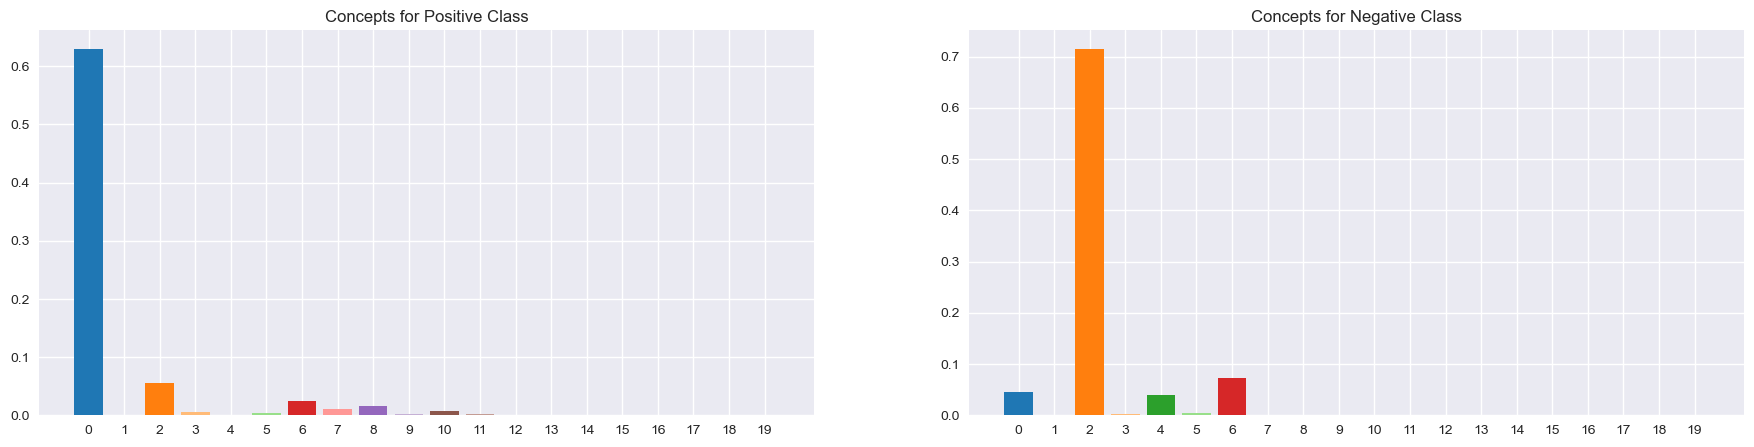

In [24]:
plt.figure(figsize=(22, 5))

plt.subplot(121)
cm = plt.get_cmap('tab20')
plt.bar(range(len(global_importance_pos)), global_importance_pos, color=cm.colors, tick_label=range(len(global_importance_pos)))
plt.title("Concepts for Positive Class")

plt.subplot(122)
cm = plt.get_cmap('tab20')
plt.bar(range(len(global_importance_neg)), global_importance_neg, color=cm.colors, tick_label=range(len(global_importance_neg)))
plt.title("Concepts for Negative Class")

plt.show()

### Visualize Occlusion's Part

In [25]:
n = 10 #number of reviews for each labels and each concept
m_pos = 2 #number of concept looked for the positive class (we look the m_pos more importants)
m_neg = 3 #number of concept looked for the negative class (we look the m_neg more importants)

# Global importance değerlerinden, pos için 2 idi ya, en yüksek 2 tanesinin idx'ini alıyor. Aynı şekilde 3 tane de neg için
# [::-1] kısım da ilgili listeleri geriden alıyor sadece
l_concept_id_pos = np.argsort(global_importance_pos)[::-1][:m_pos] # En önemli 2 pozitif concept'in id'leri
l_concept_id_neg = np.argsort(global_importance_neg)[::-1][:m_neg] # En önemli 2 negatif concept'in id'leri

l_mip_sentences_pos, l_mip_sentences_neg = [], []

# Add sentence of positive label

for concept_id in l_concept_id_pos:
    
    mip_sentences_ids = np.argsort(u_segments_pos[:, concept_id])[::-1][:n]
    mip_sentences = np.array(segments_pos)[mip_sentences_ids]
    l_mip_sentences_pos.append(mip_sentences)

# Add sentence of negative label

for concept_id in l_concept_id_neg:
    
    mip_sentences_ids = np.argsort(u_segments_neg[:, concept_id])[::-1][:n]
    mip_sentences = np.array(segments_neg)[mip_sentences_ids]
    l_mip_sentences_neg.append(mip_sentences)

l_mip_sentences_pos = np.array(l_mip_sentences_pos)
l_mip_sentences_pos = l_mip_sentences_pos.flatten()
l_mip_sentences_neg = np.array(l_mip_sentences_neg)
l_mip_sentences_neg = l_mip_sentences_neg.flatten() 

In [26]:
# Create dictionnaries for legend with a color for each concept:
# Use m_pos+m_neg concepts, so we have to create a dictionnary "colors" with m_pos+m_neg colors. 
# In the dictionnary "label_to_criterion", add the corresponding concept for each color.

colors = {
    0: "rgba(9, 221, 55, ", #green
    1: "rgba(9, 221, 161, ", #turquoise
    #2: "rgba(9, 175, 221, ", #blue
    2: "rgba(221, 9, 34, ", #red
    3: "rgba(221, 9, 140,", #pink
    4: "rgba(221, 90, 9, ", #orange
}

label_to_criterion = {
    0: "Positive label: concept1",
    1: "Positive label: concept2",
    #2: "Positive label: concept3",
    2: "Negative label: concept1",
    3: "Negative label: concept2",
    4: "Negative label: concept3",
}


#sanity check:
if len(label_to_criterion.keys()) != len(colors.keys()) or len(label_to_criterion.keys()) != (m_pos + m_neg):
    print("Error: check that you have the correct number of colors and labels in your dictionaries to cover the number of concepts being looked at")

In [27]:
print_legend(colors, label_to_criterion)

print("positive predicted reviews:")
print("\n")
i = 0
for sentence in l_mip_sentences_pos:
    if i%n == 0 :
        print("\n")
        print(str(n) + " most important reviews for positive predicted label - concept" + str(i//n + 1) +":")
        print("\n")
    phi = occlusion_concepts(sentence, model, tokenizer, [factorization_pos, factorization_neg], [l_concept_id_pos, l_concept_id_neg], ignore_words = [], two_labels = True, device = device)
    phi /= np.max(np.abs(phi)) + 1e-5
    viz_concepts(sentence, phi, colors, ignore_words = [])
    i += 1

print("\n")
print("negative predicted reviews:")
print("\n")

i = 0
for sentence in l_mip_sentences_neg:
    
    if i%n == 0 :
        print("\n")
        print(str(n) + " most important reviews for negative predicted label - concept" + str(i//n + 1) +":")
        print("\n")
    phi = occlusion_concepts(sentence,  model, tokenizer, [factorization_pos, factorization_neg], [l_concept_id_pos, l_concept_id_neg], ignore_words = [], two_labels = True, device = device)
    phi /= np.max(np.abs(phi)) + 1e-5
    viz_concepts(sentence, phi, colors, ignore_words = [])
    i +=1

positive predicted reviews:




10 most important reviews for positive predicted label - concept1:






10 most important reviews for positive predicted label - concept2:






negative predicted reviews:




10 most important reviews for negative predicted label - concept1:






10 most important reviews for negative predicted label - concept2:






10 most important reviews for negative predicted label - concept3:


